In [32]:
import torch
torch.cuda.empty_cache()  

### Параметры модели

In [33]:
CLASSES = ['window', 'backgound']
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'
#DEVICE = 'cpu'
BATCH_SIZE = 10
EPOCHS = 30
x_size = 256
y_size = 256

In [34]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

### Загрузка данных

In [35]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls /content/gdrive/"My Drive"

Mounted at /content/gdrive
'Colab Notebooks'   Files


In [36]:
!cp /content/gdrive/'My Drive'/Files/data.zip .
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: DataSet/data3/train/mask/4605.jpg  
  inflating: DataSet/data3/train/mask/4606.jpg  
  inflating: DataSet/data3/train/mask/4607.jpg  
  inflating: DataSet/data3/train/mask/4608.jpg  
  inflating: DataSet/data3/train/mask/4609.jpg  
  inflating: DataSet/data3/train/mask/4610.jpg  
  inflating: DataSet/data3/train/mask/4611.jpg  
  inflating: DataSet/data3/train/mask/4612.jpg  
  inflating: DataSet/data3/train/mask/4613.jpg  
  inflating: DataSet/data3/train/mask/4614.jpg  
  inflating: DataSet/data3/train/mask/4615.jpg  
  inflating: DataSet/data3/train/mask/4616.jpg  
  inflating: DataSet/data3/train/mask/4617.jpg  
  inflating: DataSet/data3/train/mask/4618.jpg  
  inflating: DataSet/data3/train/mask/4619.jpg  
  inflating: DataSet/data3/train/mask/4620.jpg  
  inflating: DataSet/data3/train/mask/4621.jpg  
  inflating: DataSet/data3/train/mask/4622.jpg  
  inflating: DataSet/data3/train/mask/4623.jpg  
 

In [37]:
!cp /content/gdrive/'My Drive'/Files/label_class_dict.csv .

In [38]:
!cp /content/gdrive/'My Drive'/Files/best_model_1.pth .
!cp /content/gdrive/'My Drive'/Files/best_model_2.pth .
!cp /content/gdrive/'My Drive'/Files/best_model.pth .

### Установка библиотек

In [39]:
#!pip uninstall -y segmentation-models-pytorch

In [40]:
# Catalyst
!pip install catalyst==20.10.1

# for augmentations
!pip install albumentations==0.4.3

# for pretrained segmentation models for PyTorch
!pip install segmentation-models-pytorch==0.1.0

# for TTA
!pip install ttach==0.0.2

# for tensorboard
!pip install tensorflow

# if Your machine support Apex FP16, uncomment this 3 lines below
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
# is_fp16_used = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###  Импорты библиотек


In [41]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [42]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [43]:
import albumentations as albu

In [44]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from glob import glob
from PIL import Image
 #print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

True


### Пути к данным

In [45]:
DATA_DIR = './DataSet/data3/'


In [46]:
path_save = './data/img.jpg'


path_csv = os.path.join('./label_class_dict.csv')

path_model_best = os.path.join('./best_model.pth')



x_train_dir = os.path.join(DATA_DIR, 'train/image/')
y_train_dir = os.path.join(DATA_DIR, 'train/mask/')

x_valid_dir = os.path.join(DATA_DIR, 'val/image/')
y_valid_dir = os.path.join(DATA_DIR, 'val/mask/')

x_test_dir = os.path.join(DATA_DIR, 'test/image/')
y_test_dir = os.path.join(DATA_DIR, 'test/mask/')

### Функции просмотра изображений и масок

In [47]:
# Просмотр изображений
# вывод несколько изображений 
def display(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


# Вывод изображения, оригинальной маски и предсказанной маски
def display_img(img, mask, pred):
    mask = mask.transpose(1, 2, 0).astype('float32')
    mask = mask[:,:,0]
    #img = np.reshape(img,(256,256,3))
    #mask = np.reshape(mask,(256,256,3))
    #pred = np.reshape(pred,(256,256,1))
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask,  cmap="gray")
    ax2.axis('off')
    ax3.imshow(pred,  cmap="gray")
    ax3.axis('off')

# Функции просмотра изображений и маски
def display_img_mask(img, mask):

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask,  cmap="gray")
    ax2.axis('off')
 
# Функции просмотра изображений
def display_img_mask_newMask(img, mask, new_mask):

    fig,(ax1,ax2, ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask,  cmap="gray")
    ax2.axis('off')
    ax3.imshow(new_mask,  cmap="gray")
    ax3.axis('off')



def display_mask(img):
  fig, ax = plt.subplots()
  ax.imshow(img,  cmap="gray")
  fig.set_figwidth(6)    #  ширина и
  fig.set_figheight(6)    #  высота "Figure"
  plt.show()    

### DataSet

Вспомогательный класс  для извлечения предварительной обработки данных
https://pytorch.org/docs/stable/data

In [48]:
# from sklearn.model_selection import train_test_split

In [49]:
class Dataset(BaseDataset):
    """
    
    images_dir: Путь к папке с изображениями

    masks_dir: Путь к папке с масками
    
    """
    CLASSES = ['window', 'backgound']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask1 = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        ret, mask = cv2.threshold(mask1, 127, 255, cv2.THRESH_BINARY)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

#### просмотр   изображения и маски

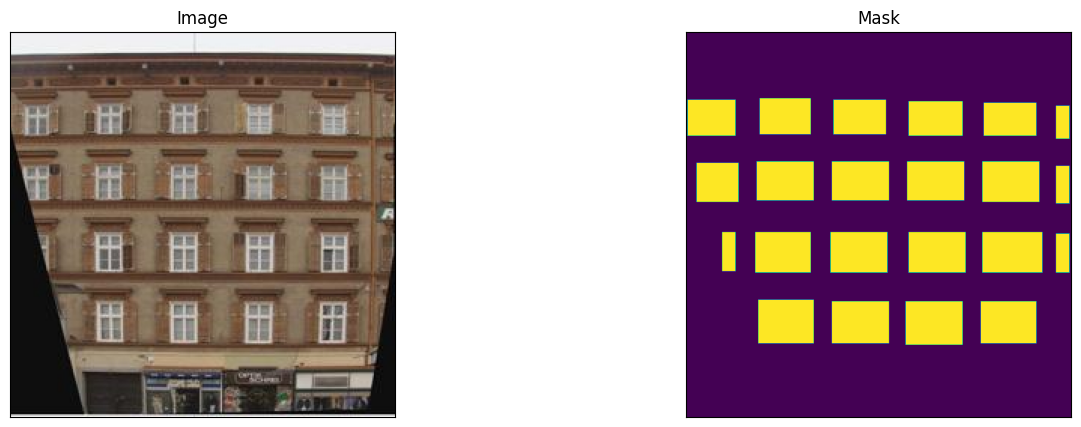

In [50]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['window'])
#dataset = Dataset(x_train_dir, y_train_dir)
image, mask = dataset[0] 

display(
    image=image, 
    mask=mask,
)

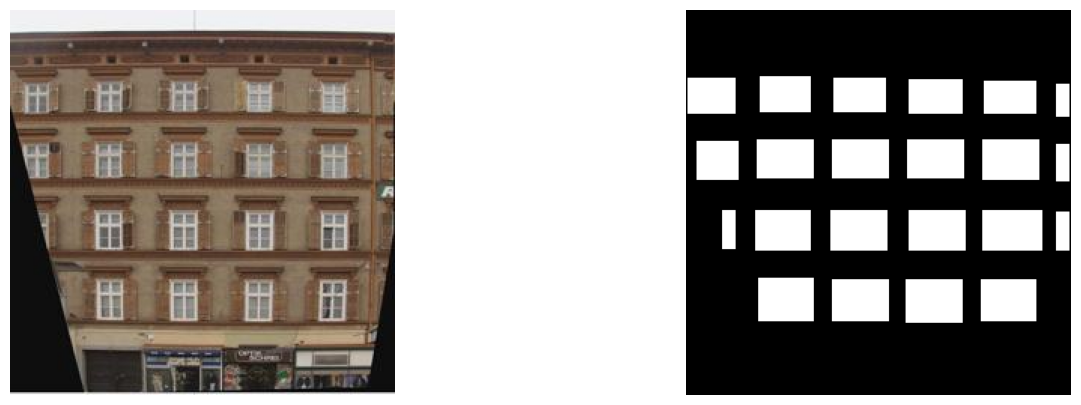

In [51]:
display_img_mask(image, mask.squeeze())

### Аугментация


In [52]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=y_size, min_width=x_size, always_apply=True, border_mode=0),
        albu.RandomCrop(height=y_size, width=x_size, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.PadIfNeeded(y_size, x_size)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

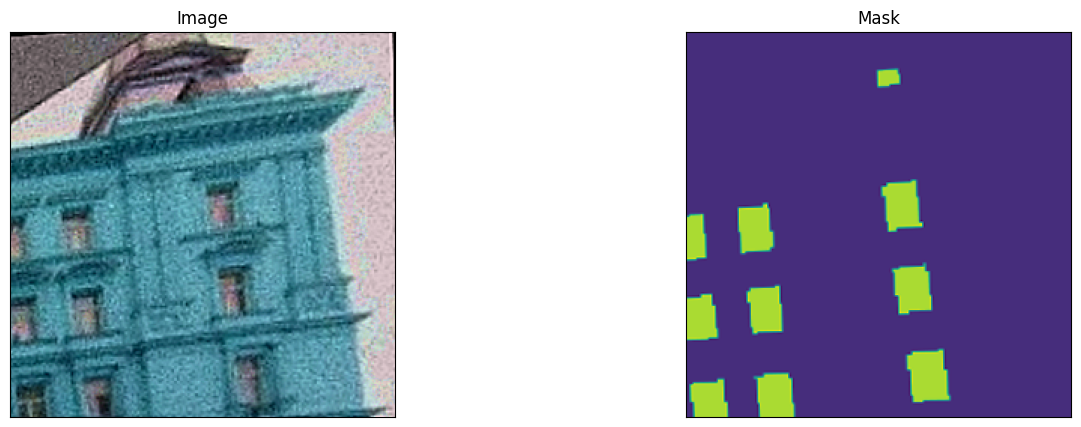

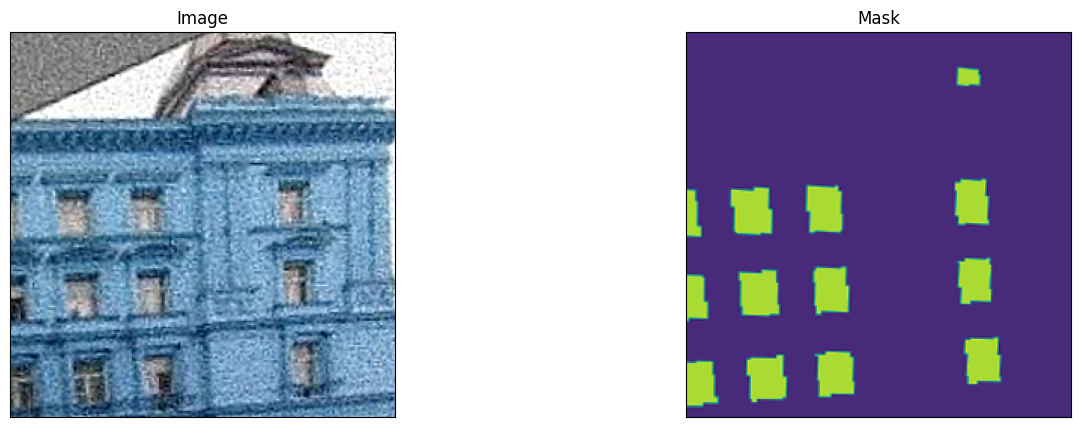

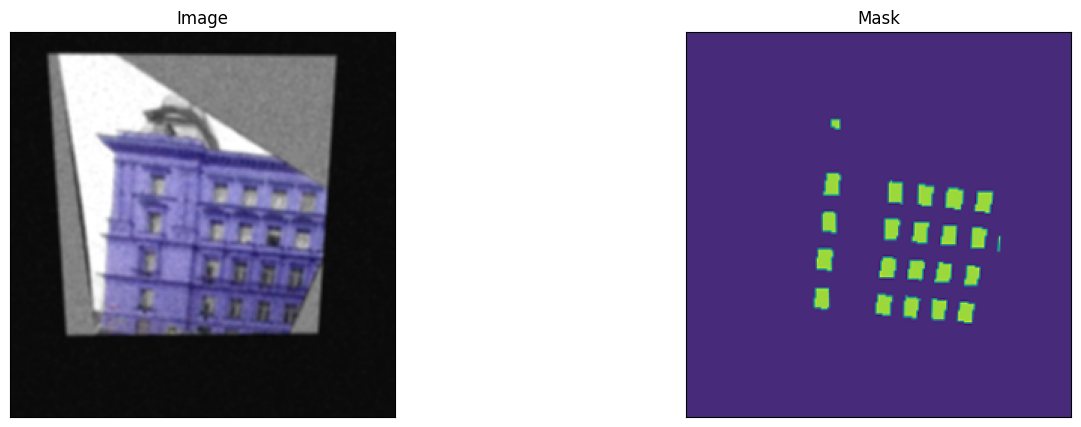

In [53]:
# Просмотр применения аугментации

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['window'],
)


for i in range(3):
    image, mask = augmented_dataset[5]
    display(image=image, mask=mask.squeeze(-1))

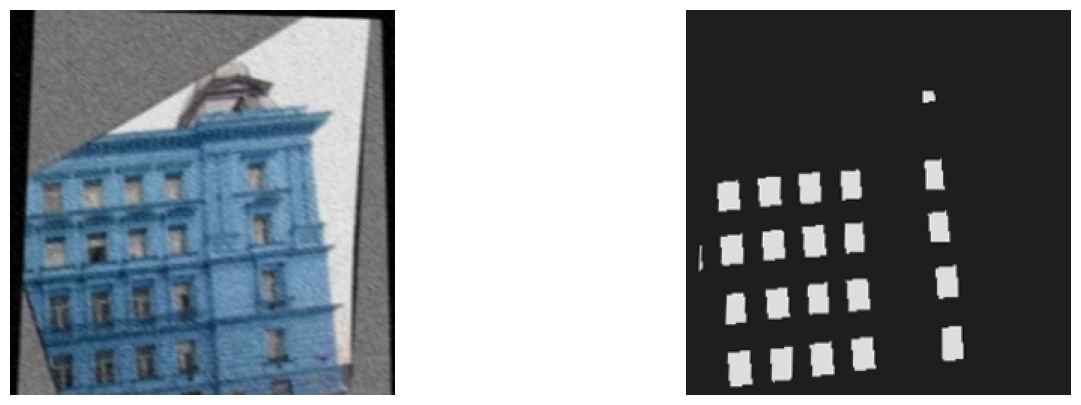

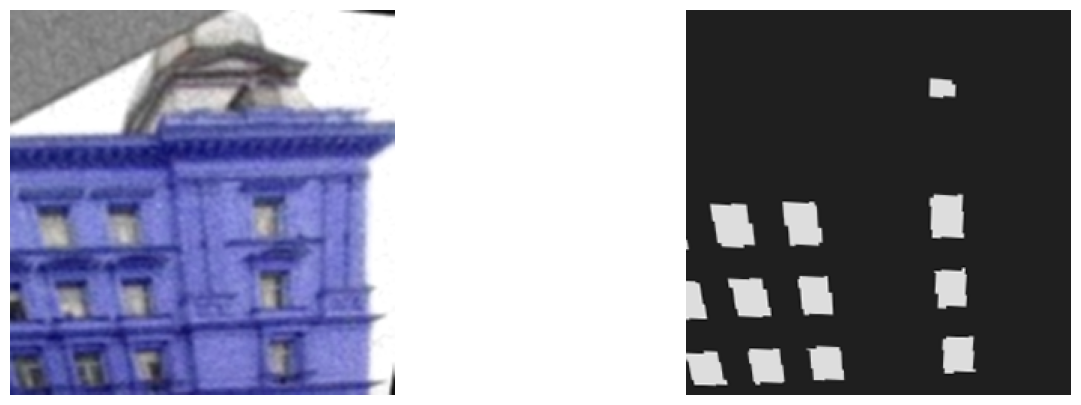

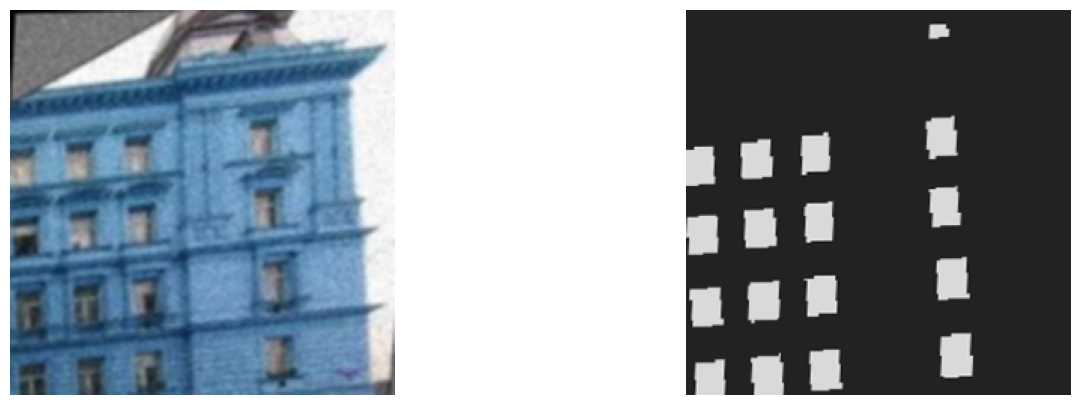

In [54]:
for i in range(3):
    image, mask = augmented_dataset[5]
    display_img_mask(image, mask=mask.squeeze(-1))



## Модель

In [55]:
#
#   Создаём модель
#
#   Энкодер - resnet50
#
#   Предобученные веса -  imagenet
#

model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)



In [56]:
# ЗАГРУЗКА МОДЕЛИ (Ранее сохранённой натренированной модели)
model = torch.load('./best_model_2.pth', map_location=torch.device(DEVICE))

In [57]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

фомируем датасеты

In [58]:


# тренировачный датасет
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# проверочный датасет
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)



In [59]:
# Загрузка датасетов
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=1)

In [60]:

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [61]:

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Тренировка модели

In [62]:
# ТРЕНИРОВКА МОДЕЛИ

max_score = 0

EPOCHS = 42

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_2.pth')
        print('Model saved!')
        
    if i % 20 == 0:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10
        print('Изменение - learning rate: ', optimizer.param_groups[0]['lr'])


Epoch: 0
valid: 100%|██████████| 101/101 [00:07<00:00, 12.96it/s, dice_loss - 0.2321, iou_score - 0.6246]
Model saved!
Изменение - learning rate:  0.0001

Epoch: 1
valid: 100%|██████████| 101/101 [00:09<00:00, 11.16it/s, dice_loss - 0.2009, iou_score - 0.667]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:07<00:00, 12.90it/s, dice_loss - 0.192, iou_score - 0.6793]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:08<00:00, 11.53it/s, dice_loss - 0.1898, iou_score - 0.6823]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:08<00:00, 11.36it/s, dice_loss - 0.1863, iou_score - 0.6873]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:07<00:00, 13.06it/s, dice_loss - 0.1876, iou_score - 0.6856]

Epoch: 6
valid: 100%|██████████| 101/101 [00:08<00:00, 11.32it/s, dice_loss - 0.18, iou_score - 0.6963]
Model saved!

Epoch: 7
valid: 100%|██████████| 101/101 [00:07<00:00, 13.06it/s, dice_loss - 0.1786, iou_score - 0.6982]
Model saved!

Epoch: 8
valid: 100%|

## ПРОВЕРКА НА ТЕСТОВОМ НАБОРЕ


In [63]:
# ЗАГРУЗКА МОДЕЛИ
model = torch.load('./best_model_2.pth', map_location=torch.device(DEVICE))

In [64]:
# формирование тестового датасета
test_dataset1 = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# Загрузка тестового датасета
test_dataloader = DataLoader(test_dataset)

In [95]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:2907: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


In [96]:
# Оценка модели тестовым набором
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 251/251 [00:05<00:00, 48.96it/s, dice_loss - 0.1263, iou_score - 0.7808]


###  Просмотр предсказанных изображений

In [97]:
# загрузка тренировачного датасета
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [98]:
for i in range(10):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    display_img(image_vis, gt_mask, pr_mask )  



Output hidden; open in https://colab.research.google.com to view.

## ПОДСЧЁТ КОЛИЧЕСТВА ОКОН

#### Вспомогательные функции для подсчёта окон

In [99]:
# функция проверяет принадлежит ли точка ранее найденному окну?
def belong(x, y, set_point: list):
    if (set_point[0] <= x <= set_point[2]) and (set_point[1] <= y <= set_point[3]):
        return True
    else:
        return False
                        

In [100]:
# Поиск всех точек принадлежащих новому окну
def search_points(a, b, img5):
    img = img5
    # list_points_window = [0, 0, 0, 0]  # Список содержащий угловые точки окна
    x0 = a   # точка начала движения
    y0 = b
    
    y1 = b    # текущий номер верхней строки окна
    x1 = a    # текущий номер левого столбца окна
    y2 = b    # текущий номер нижней строки окна
    x2 = a    # текущий номер правого столбца окна
    
    x = a     #  текущее положение точки
    y = b
    
    mov = 'RIGHT'   #   направление движения (начинаем движение вправо)
    flag_round = False
    
    while flag_round == False:  # Пока не вернулись в исходную точку, обходим точки окна          
        if mov == 'NONE': # Если единственный пиксель чёрный
            continue
        if mov == 'RIGHT': # движемся вправо
            list1 = right_mov(x, y, img)  # выбираем новую точку и направление движения
            xx = list1[0] 
            if x1 > list1[0]:
                x1 = list1[0]
            if x2 < list1[0]:
                x2 = list1[0]
            if y1 > list1[1]:
                y1 = list1[1]
            if y2 < list1[1]:
                y2 = list1[1]
            x = list1[0]
            y = list1[1]
            mov = list1[2]
            flag_round =( x0 == x and y0 == y)
            continue          

        if mov == 'LEFT': # движемся влево
            list1 = left_mov(x, y, img)  # выбираем новую точку и направление движения  
            if x1 > list1[0]:
                x1 = list1[0]
            if x2 < list1[0]:
                x2 = list1[0]
            if y1 > list1[1]:
                y1 = list1[1]
            if y2 < list1[1]:
                y2 = list1[1]
            x = list1[0]
            y = list1[1]
            mov = list1[2]
            flag_round =( x0 == x and y0 == y)
            continue
                        
        if mov == 'DOWN': # движемся вниз
            list1 = down_mov(x, y, img)  # выбираем новую точку и направление движения 
         
            if x1 > list1[0]:
                x1 = list1[0]
            if x2 < list1[0]:
                x2 = list1[0]
            if y1 > list1[1]:
                y1 = list1[1]
            if y2 < list1[1]:
                y2 = list1[1]
            x = list1[0]
            y = list1[1]
            mov = list1[2]
            flag_round =( x0 == x and y0 == y)
            continue     

        if mov == 'UP': # движемся вверх
            list1 = up_mov(x, y, img)  # выбираем новую точку и направление движения
            if x1 > list1[0]:
                x1 = list1[0]
            if x2 < list1[0]:
                x2 = list1[0]
            if y1 > list1[1]:
                y1 = list1[1]
            if y2 < list1[1]:
                y2 = list1[1]
            x = list1[0]
            y = list1[1]
            mov = list1[2]
            flag_round =( x0 == x and y0 == y)
            continue  
            
    list_points_window = [x1, y1, x2, y2] 

    vv = 0
    return  list_points_window    


In [88]:
# функция движения вправо
def right_mov(x, y, img):  #  Выбираем направление  продолжения движения
    size = 255
    if y  > 0 and img[x, y - 1] == 0:
        mov = 'UP'
        y = y - 1
        return [x, y, mov]
    if x < size and img[x + 1, y] == 0:
        mov = 'RIGHT'
        x = x + 1
        return [x, y, mov]  
    if y < size and img[x, y + 1] == 0:
        mov = 'DOWN'
        y = y + 1
        return [x, y, mov]    
    if x > 0 and img[x - 1, y] == 0:
        mov = 'LEFT'
        x = x - 1
        return [x, y, mov]
    else:
        mov = 'NONE'
        return [x, y, mov]
    
# функция движения влево
def left_mov(x, y, img):
    size = 255
    if y < size and img[x, y + 1] == 0:
        mov = 'DOWN'
        y = y + 1
        return [x, y, mov]    
    if x > 0 and img[x - 1, y] == 0:
        mov = 'LEFT'
        x = x - 1
        return [x, y, mov] 
    if y > 0 and img[x, y - 1] == 0:
        mov = 'UP'
        y = y - 1
        return [x, y, mov] 
    if x < size and img[x + 1, y] == 0:
        mov = 'RIGHT'
        x = x + 1
        return [x, y, mov] 
    else:
        mov = 'NONE'
        return [x, y, mov]    

# функция движения вниз
def down_mov(x, y, img):
    size = 255
    if x < size and img[x + 1, y] == 0:
        mov = 'RIGHT'
        x = x + 1
        return [x, y, mov]  
    if y < size and img[x, y + 1] == 0:
        mov = 'DOWN'
        y = y + 1
        return [x, y, mov]    
    if x > 0 and img[x - 1, y] == 0:
        mov = 'LEFT'
        x = x - 1
        return [x, y, mov] 
    if y > 0 and img[x, y - 1] == 0:
        mov = 'UP'
        y = y - 1
        return [x, y, mov]    
    else:
        mov = 'NONE'
        return [x, y, mov]
    
# функция движения вверх
def up_mov(x, y, img): 
    size = 255
    if x > 0 and img[x - 1, y] == 0:
        mov = 'LEFT'
        x = x - 1
        return [x, y, mov] 
    if y > 0 and img[x, y - 1] == 0:
        mov = 'UP'
        y = y - 1
        return [x, y, mov] 
    if x < size and img[x + 1, y] == 0:
        mov = 'RIGHT'
        x = x + 1
        return [x, y, mov] 
    if y < size and img[x, y + 1] == 0:
        mov = 'DOWN'
        y = y + 1
        return [x, y, mov]    
    else:
        mov = 'NONE'
        return [x, y, mov]    
     
    

In [89]:
# функция преобразования изображения
def funcImg(img):
  size_x, size_y =  img.shape
  array_img = np.zeros((size_x, size_y))
  for x in range(size_x):
    for y in range(size_y):
      if img[x, y] == 0:
        array_img[x, y] = 255
      else:
        array_img[x, y] = 0
  return array_img     

In [90]:
def func_mask(img, array_mask_windows):  
  #size_x, size_y, ee = img.shape
  size_x, size_y = img.shape
  img_new = np.ones((size_x, size_y))
  for x in range(size_x):
      for y in range(size_y):
          for list_w in array_mask_windows:
              flag = belong(x, y, list_w)
              if flag == True:
                  img_new[x,y] = 0
                  break
              else:
                  img_new[x,y] = 255
  return img_new

### Основная функция подсчёта

In [91]:
# функция подсчёта возвращает количество окон и список угловых точек всех окон
def calc_windows(img):
    list_windows = []    # Список содеражщий информацию о всех окнах
    list_points_window = []  # Список содержащий угловые точки окна
    count_windows = 0 # количество найденных окон
    #img2 = img[:,:,0]
    img2 = img
    size_x, size_y = img2.shape
    flag = False  # Флаг цвета точки
    for x in range(size_x):
        for y in range(size_y):
            if img2[x, y] == 0:
                flag2 = False  # флаг принадлежит ли текущая точка ранее найденному окну?
                if list_windows:                   
                    for list_w in list_windows:               
                        flag2 = belong(x, y, list_w)
                        if flag2==True:   # Если точка принадлежит окну, выходим
                            break
                if flag2==False:  # b
                    count_windows = count_windows + 1
                    list_points_window = search_points(x, y, img2) # ищем окно которому принадлежит точка 
                    list_windows.append(list_points_window)      # добавляем в список окно  
                   
        
    return  count_windows, list_windows         

In [117]:
# функция сегментации
def segmenation_fasads(num):
  image, gt_mask = test_dataset[num]
  x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
  pr_mask = model.predict(x_tensor)
  pr_mask1 = (pr_mask.squeeze().cpu().numpy().round())
  image1 = image.transpose(1, 2, 0).astype('float32')
  img_mask = funcImg(pr_mask1)

  # array_mask_windows - массив угловых точек окон
  # count_windows   -  количество окон
  count_windows, array_mask_windows = calc_windows(img_mask)
  print('Количество окон: ', count_windows)
  mask_new = func_mask(img_mask, array_mask_windows)
  display_img_mask_newMask(image1, img_mask, mask_new)
  #ret,img11 = cv2.threshold(pr_mask,127,255,cv2.THRESH_BINARY)



  img_save = cv2.imwrite(path_save, img_mask)

# ПРОВЕРКА РАБОТЫ

In [2]:
#
#    Обработем изображение
#
#  1) Вывод количества окон на изображении
#  2) Само изображение
#  3) сгенерированное изображение маски
#  4) улучшенное изображение полученной маски
#
#
#   num - Номер в тестовом датасете
#

num = 0
segmenation_fasads(num)

NameError: ignored

In [77]:
import gc
del valid_epoch
gc.collect()   
del train_epoch
del train_loader
del valid_loader
del train_dataset
gc.collect()   

0

In [78]:
torch.cuda.empty_cache()  